# Convert to HDF5
Convert the COMSOL simulation data of flow cells from pickled files into a list of HDF5s, one per experiment.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from batdata.postprocess.cycle_stats import CycleTimes
from batdata.schemas import BatteryMetadata, BatteryDescription, ModelMetadata
from batdata.data import BatteryDataset
from tarfile import TarFile
from shutil import rmtree
from pathlib import Path
from tqdm import tqdm
import pickle as pkl
import pandas as pd
import numpy as np
import yaml

Configuration

In [2]:
with open('parameters.yml') as fp:
    parameters = yaml.safe_load(fp)
cell_active_area = 780 / 1e4 # In m^2

## Explain the Data Format

The simulation results form each data are stored in a pickled dictionary that contains two keys:
- `degradation_parameters`: A listing of the parmaeters of the model and how they change per cycle
- `res_multi`: The data for the charge and discharge

Read an example file

In [3]:
%%time
with TarFile.gzopen('raw/data.tar.gz') as t:
    with t.extractfile('data/results_Case_4672.pkl') as fp:
        case_data = pkl.load(fp)
case_data.keys()

CPU times: user 28.3 s, sys: 2.14 s, total: 30.4 s
Wall time: 30.5 s


dict_keys(['Case', 'degradation_parameters', 'res_multi'])

The degredatation parameters contains a listing of function describing how the parameters have decayed over time:

- `Type`: Whether the parameter is changing or not
- `Mode`: Which function defines degradation (Constant, Linear, Power Law, Tanh)
- `coef`: Coefficients describing the degreadation
- `PV`: Values of the parameter for each cycle
- `PR`: Range of the parameters between first and last cycle

In [4]:
case_params = case_data['degradation_parameters']
print(f'Loaded information for {len(case_params)} parameters')

Loaded information for 12 parameters


In [5]:
case_params[0].keys()

dict_keys(['Type', 'Mode', 'coef', 'PV', 'PR'])

The output data contains a separate entry for each cycle.

Each entry contains an array of the elapsed time (hrs), state of charge, and voltage (V) in both charge and discharge.

The current is defined by the "Applied Current" parameter and the cell active area (configured above)

In [6]:
case_results = case_data['res_multi']
print(f'Loaded results for {len(case_results)} cycles')

Loaded results for 501 cycles


In [7]:
case_results[1].keys()

dict_keys(['Charge', 'Discharge'])

In [8]:
case_results[1]['Charge'].shape

(98, 3)

### Functions to Extract Data and Metadata
So that we can easily process a new file

Make a function which produces the "raw data" signal over time

In [9]:
def make_raw_data(case_data: dict) -> pd.DataFrame:
    """Store the current, voltage and SOC as a function of time

    Args:
        case_data: Data for this particular case
    Returns:
        Dataframe in "raw data format"
    """

    # Compile each cycle separately
    all_cycles = []
    cycle_start = 0  # Start time for a cycle in seconds
    for cyc_id, results in enumerate(case_data['res_multi']):
        cycle = []
        for step_id, stage in enumerate(['Charge', 'Discharge']):  # TODO (wardlt): Should we assume charge first?
            subcycle = pd.DataFrame(results[stage], columns=['test_time', 'soc', 'voltage'])

            # Convert the time to seconds and move the start time forward
            subcycle['test_time'] = subcycle['test_time'] * 3600 + cycle_start
            cycle_start = subcycle['test_time'].iloc[-1]

            # Add the current based on the parameter values
            current_param = case_data['degradation_parameters'][10]
            assert parameters[10]['name'] == 'Applied current'
            subcycle['current'] = current_param['PV'][cyc_id] * cell_active_area
            if stage == 'Charge': 
                subcycle['current'] *= -1

            # Mark the step index and whether the battery is charging or discharging
            subcycle['step_index'] = step_id
            subcycle['state'] = stage.lower()[:-1] + 'ing'
            cycle.append(subcycle)

        # Append to the total list
        cycle = pd.concat(cycle, ignore_index=True)
        cycle['cycle_number'] = cyc_id
        all_cycles.append(cycle)

    return pd.concat(all_cycles, ignore_index=True)
raw_data = make_raw_data(case_data)

Text(0.5, 0, 'Time (hr)')

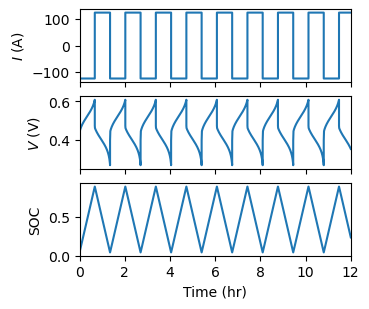

In [10]:
fig, axs = plt.subplots(3, 1, figsize=(3.5, 3.2), sharex=True)

for ax, c, l in zip(axs, ['current', 'voltage', 'soc'], ['$I$ (A)', '$V$ (V)', 'SOC']):
    ax.plot(raw_data['test_time'] / 3600, raw_data[c])
    ax.set_ylabel(l)

axs[0].set_xlim(0., 12.)
axs[-1].set_xlabel('Time (hr)')

Make a function which generates cycle-level summaries

In [11]:
def make_cycle_summary(case_data: dict, raw_data: pd.DataFrame) -> pd.DataFrame:
    """Summarize the available data about each case.

    Store the parameters for the datasets

    Args:
        case_data: Data for this particular case
        raw_data: Raw data for each of the cycles
    Returns:
        Dataframe in "raw data format"
    """

    # Initialize
    cycle_count = raw_data['cycle_number'].max() + 1
    cycle_stats = pd.DataFrame({'cycle_number': np.arange(cycle_count)})

    # Store the values for each parameter for each cycle
    for i, info in enumerate(parameters):
        name = info['name'].replace(" ", "_").lower()
        cycle_stats[name] = case_data['degradation_parameters'][i]['PV']

    return cycle_stats
cycle_stats = make_cycle_summary(case_data, raw_data)

Text(0.5, 0, 'Cycle')

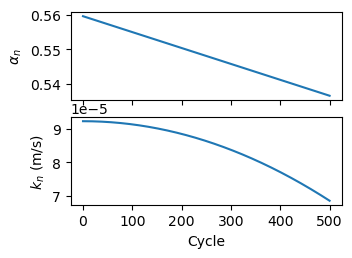

In [12]:
fig, axs = plt.subplots(2, figsize=(3.5, 2.5), sharex=True)

for ax, c, l in zip(axs, ['reaction_transfer_coefficient', 'reaction_rate_constant'], ['$\\alpha_n$', '$k_n$ (m/s)']):
    ax.plot(cycle_stats['cycle_number'], cycle_stats[c])
    ax.set_ylabel(l)

axs[-1].set_xlabel('Cycle')

Make the metadata for the dataset, including the degredation models for the parameters

In [13]:
def make_metadata(case_data: dict) -> BatteryMetadata:
    """Summarize the source of the data, including the degredation model

    Args:
        case_data: Description of this dataset
    Returns:
        Metadata ready for use in HDF5
    """
    # Convert the degredation style into a summary
    parameter_summary = []
    for i, info in enumerate(parameters):
        param = case_data['degradation_parameters'][i]
        parameter_summary.append({
            **info,
            'degradation_mode': ['Constant', 'Linear', 'Power Law', 'Tanh'][param['Mode']],
            'degradation_coeff': list(param['coef']),
            'parameter_range': list(param['PR']),  # List can be converted to JSON, ndarray cannot
        })

    # Load the cycle descriptions
    
    return BatteryMetadata(
        name=f'ezbatt_{case_data["Case"]}',
        source='bao_ezbatt',
        # battery=BatteryDescription(),  # TBD: Need to include flow cell terms
        modeling=ModelMetadata(
            name='EZBattery',
            version='',
            type='physics',
            models=['BatteryContinuumModel'],
            simulation_type='StandaloneModelSimulation',
            references=[
                'https://iopscience.iop.org/article/10.1149/1945-7111/acadad',
                'https://doi.org/10.1016/j.jpowsour.2020.228817',
                'https://doi.org/10.1016/j.jpowsour.2021.230192',
                'https://doi.org/10.1016/j.jpowsour.2023.233210',
            ],
            parameter_summary=parameter_summary
        ),
        raw_data_columns={'soc': 'Fractional state of charge'},
        cycle_stats_columns=dict(
            (p['name'].replace(" ", "_").lower(), f"{p['description']} (Units: {p['units']})")
            for p in parameters
        )
    )
make_metadata(case_data).model_dump(exclude_unset=True)

{'name': 'ezbatt_4673',
 'modeling': {'name': 'EZBattery',
  'version': '',
  'type': <ModelTypes.physics: 'physics'>,
  'references': [Url('https://iopscience.iop.org/article/10.1149/1945-7111/acadad'),
   Url('https://doi.org/10.1016/j.jpowsour.2020.228817'),
   Url('https://doi.org/10.1016/j.jpowsour.2021.230192'),
   Url('https://doi.org/10.1016/j.jpowsour.2023.233210')],
  'models': ['BatteryContinuumModel'],
  'simulation_type': 'StandaloneModelSimulation',
  'parameter_summary': [{'name': 'Reaction transfer coefficient',
    'description': 'A measure of the symmetry of the two directions of the reaction.',
    'symbol': '\\alpha_n',
    'units': 'unitless',
    'degradation_mode': 'Linear',
    'degradation_coeff': [8.227922946912769e-05, 0.0],
    'parameter_range': [0.559553, 0.5365332051564305]},
   {'name': 'Electrode specific area',
    'description': 'The ratio between the total electrode microstructure surface area and the total volume of the electrode.',
    'symbol': 'a

## Convert All Cases
Read all cases from the dictionary then save them as HDF5

In [14]:
out_dir = Path('processed')
if out_dir.exists():
    rmtree(out_dir)
out_dir.mkdir()

In [15]:
with TarFile.gzopen('raw/data.tar.gz') as tar:
    # Loop over all PKL files
    for file in tqdm(tar.getmembers()):
        if not file.name.endswith('.pkl'):
            continue

        # Read it
        with tar.extractfile(file) as fp:
            case_data = pkl.load(fp)

        # Parse the data and assemble into an object
        raw_data = make_raw_data(case_data)
        cycle_stats = make_cycle_summary(case_data, raw_data)
        metadata = make_metadata(case_data)
        data = BatteryDataset(
            raw_data=raw_data, cycle_stats=cycle_stats, metadata=metadata
        )
        assert len(data.validate()) == 0  # No warnings about unlabeled columns

        # Compute the cycle times
        CycleTimes().compute_features(data)

        # Save it to HDF5 
        path = out_dir / f'{metadata.name}.h5'
        data.to_batdata_hdf(path, complevel=9)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8203/8203 [1:57:28<00:00,  1.16it/s]
